In [1]:
import sys
print(sys.executable)

/home/shrey/miniconda3/envs/LLMIdentifiersEnv/bin/python


In [2]:
!/home/shrey/miniconda3/envs/LLMIdentifiersEnv/bin/python -m pip install hf_xet

In [3]:
import json
import os
import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import convokit
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns

In [4]:
# Load data
folder_path = "results/"
data = []

for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith(".json"):
            file_path = os.path.join(root, filename)
            try:
                with open(file_path, "r") as f:
                    entry = json.load(f)
                    data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Skipped invalid JSON: {file_path} ({e})")

print(f"Loaded {len(data)} valid JSON result files from '{folder_path}' and its subfolders.")

Loaded 295 valid JSON result files from 'results/' and its subfolders.


In [5]:
def normalize(model_name: str) -> str:
    """Simple normalization to compare model names."""
    return model_name.lower().replace("**", "").strip()

def correct_guess(guess: str, answer: str) -> bool:
    """Check if any meaningful word (>=3 letters) from guess appears in answer."""
    words = re.split(r"[^a-zA-Z]+", guess)  # split on anything NOT a-z or A-Z
    for word in words:
        if len(word) >= 3 and word.lower() in answer.lower():
            return True
    return False

In [6]:
def evaluate_being_guessed(game_data_list):
    total = 0
    correct = 0
    per_model_stats = defaultdict(lambda: {"correct": 0, "total": 0})

    for entry in game_data_list:
        model_0 = normalize(entry["model_general_name_0"])
        model_1 = normalize(entry["model_general_name_1"])
        guess_0 = normalize(entry["agent_0_guess"])
        guess_1 = normalize(entry["agent_1_guess"])

        # agent_0 is guessing model_1
        per_model_stats[model_1]["total"] += 1
        if correct_guess(guess_0, model_1):
            correct += 1
            per_model_stats[model_1]["correct"] += 1
        
        # agent_1 is guessing model_0
        per_model_stats[model_0]["total"] += 1
        if correct_guess(guess_1, model_0):
            correct += 1
            per_model_stats[model_0]["correct"] += 1

        total += 2  # Two guesses per run

    overall_accuracy = correct / total

    per_model_accuracy = {
        model: round(stats["correct"] / stats["total"], 3)
        for model, stats in per_model_stats.items()
    }

    return overall_accuracy, per_model_accuracy

Overall Accuracy: 3.73%
Per-Model Accuracy:
  llama: 8.70%
  qwen: 0.40%
  deepseek: 0.00%
  gpt: 0.00%


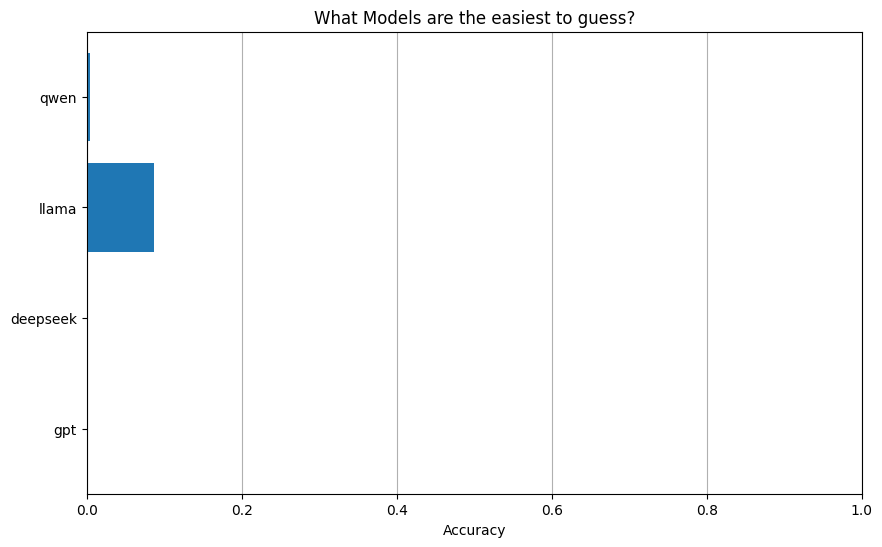

In [7]:
overall_acc, per_model_acc = evaluate_being_guessed(data)
print(f"Overall Accuracy: {overall_acc:.2%}")
print("Per-Model Accuracy:")
for model, acc in sorted(per_model_acc.items(), key=lambda x: x[1], reverse=True):
    print(f"  {model}: {acc:.2%}")

models = list(per_model_acc.keys())
accuracies = [per_model_acc[m] for m in models]

plt.figure(figsize=(10, 6))
plt.barh(models, accuracies)
plt.xlabel("Accuracy")
plt.title("What Models are the easiest to guess?")
plt.xlim(0, 1)  # Accuracy goes from 0 to 1
plt.gca().invert_yaxis()  # Highest accuracy at the top
plt.grid(axis='x')
plt.show()


In [8]:
def evaluate_guessing(game_data_list):
    total = 0
    correct = 0
    per_model_stats = defaultdict(lambda: {"correct": 0, "total": 0})

    for entry in game_data_list:
        model_0 = normalize(entry["model_general_name_0"])
        model_1 = normalize(entry["model_general_name_1"])
        guess_0 = normalize(entry["agent_0_guess"])
        guess_1 = normalize(entry["agent_1_guess"])

        # model_0 is making the guess at model_1
        per_model_stats[model_0]["total"] += 1
        if correct_guess(guess_0, model_1):
            correct += 1
            per_model_stats[model_0]["correct"] += 1

        # model_1 is making the guess at model_0
        per_model_stats[model_1]["total"] += 1
        if correct_guess(guess_1, model_0):
            correct += 1
            per_model_stats[model_1]["correct"] += 1

        total += 2

    overall_accuracy = correct / total

    per_guesser_accuracy = {
        model: round(stats["correct"] / stats["total"], 3)
        for model, stats in per_model_stats.items()
    }

    return overall_accuracy, per_guesser_accuracy, per_model_stats

Overall Guesser Accuracy: 3.73%
Per-Guesser Model Accuracy:
  qwen: 9.20%
  deepseek: 0.80%
  llama: 0.00%
  gpt: 0.00%
Guesser correct guesses and attempts:
  qwen: 21 / 229 correct
  deepseek: 1 / 118 correct
  llama: 0 / 242 correct
  gpt: 0 / 1 correct


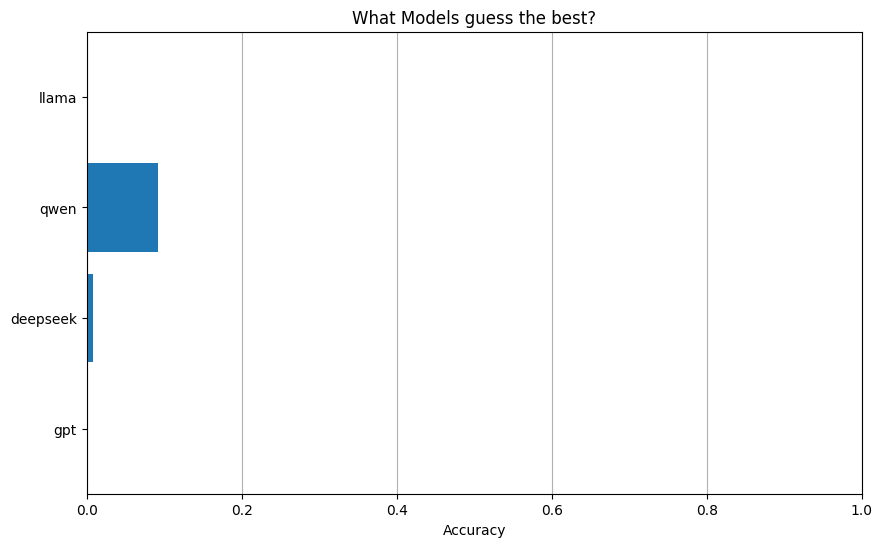

In [9]:
# Run evaluation for guessers
guesser_overall_acc, per_guesser_acc, guesser_stats = evaluate_guessing(data)

print(f"Overall Guesser Accuracy: {guesser_overall_acc:.2%}")
print("Per-Guesser Model Accuracy:")
for model, acc in sorted(per_guesser_acc.items(), key=lambda x: x[1], reverse=True):
    print(f"  {model}: {acc:.2%}")

# Optional: see raw counts
def print_guesser_counts(guesser_stats):
    print("Guesser correct guesses and attempts:")
    for model, stats in sorted(guesser_stats.items(), key=lambda x: x[1]["correct"], reverse=True):
        print(f"  {model}: {stats['correct']} / {stats['total']} correct")

print_guesser_counts(guesser_stats)

models_2 = list(per_guesser_acc.keys())
accuracies_2 = [per_guesser_acc[m] for m in models_2]

plt.figure(figsize=(10, 6))
plt.barh(models_2, accuracies_2)
plt.xlabel("Accuracy")
plt.title("What Models guess the best?")
plt.xlim(0, 1)  # Accuracy goes from 0 to 1
plt.gca().invert_yaxis()  # Highest accuracy at the top
plt.grid(axis='x')
plt.show()

In [10]:
def collect_guessed_models(data):
    guessed_models_by_guesser = defaultdict(lambda: defaultdict(int))

    for entry in data:
        model_0 = normalize(entry["model_0"])  # agent_0 (guesser)
        model_1 = normalize(entry["model_1"])  # agent_1 (guesser)

        guess_0 = normalize(entry["agent_0_guess"]).split(" ")[0]
        guess_1 = normalize(entry["agent_1_guess"]).split(" ")[0]

        # model_0 guesses model_1
        guessed_models_by_guesser[model_1][guess_1] += 1

        # model_1 guesses model_0
        guessed_models_by_guesser[model_1][guess_1] += 1

    return guessed_models_by_guesser

No guesses recorded for meta-llama/llama-3.3-70b-instruct
No guesses recorded for deepseek/deepseek-r1-distill-llama-70b


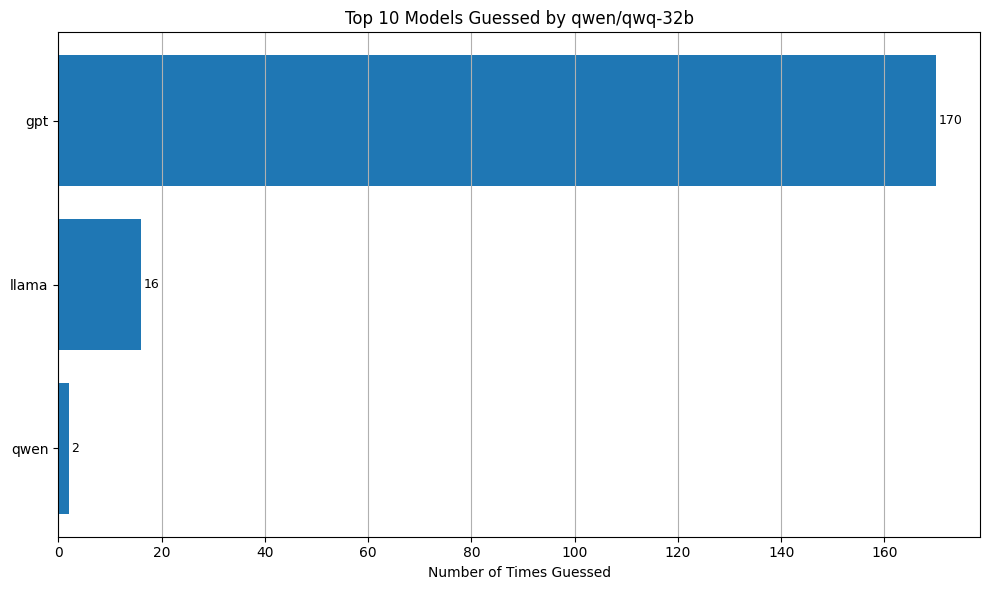

In [11]:
def plot_model_guesses(guesser_name, guessed_models_by_guesser, top_n=10):
    guesses = guessed_models_by_guesser.get(guesser_name, {})
    if not guesses:
        print(f"No guesses recorded for {guesser_name}")
        return

    models = list(guesses.keys())
    counts = [guesses[m] for m in models]

    # Sort from most guessed to least guessed
    sorted_pairs = sorted(zip(models, counts), key=lambda x: x[1], reverse=True)

    # Take top N
    top_pairs = sorted_pairs[:top_n]
    other_pairs = sorted_pairs[top_n:]

    # Calculate "Others"
    if other_pairs:
        others_count = sum(count for _, count in other_pairs)
        top_pairs.append(("Others", others_count))

    sorted_models = [m for m, _ in top_pairs]
    sorted_counts = [c for _, c in top_pairs]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(sorted_models[::-1], sorted_counts[::-1])  # Reverse for top-down

    plt.xlabel("Number of Times Guessed")
    plt.title(f"Top {top_n} Models Guessed by {guesser_name}")
    plt.grid(axis="x")

    for bar, count in zip(bars, sorted_counts[::-1]):
        plt.text(count + 0.5, bar.get_y() + bar.get_height() / 2,
                 str(count), va="center", ha="left", fontsize=9)

    plt.tight_layout()
    
guessed_models_by_guesser = collect_guessed_models(data)


plot_model_guesses("meta-llama/llama-3.3-70b-instruct", guessed_models_by_guesser)
plot_model_guesses("qwen/qwq-32b", guessed_models_by_guesser)
plot_model_guesses("deepseek/deepseek-r1-distill-llama-70b", guessed_models_by_guesser)